In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.svm import SVR
from itertools import product

In [2]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
X_train, X_test, y_train, y_test = train_test_split(*make_classification(n_samples=10000,n_features=200))

In [48]:
parameter_space = {'n_estimators':[2,200],
                  'max_depth':[2,40],
                  'min_samples_split':[2,100],
#                   'min_samples_leaf':[2,200],
                  }
  

In [49]:
set(product(list(range(3)), repeat=3))

{(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)}

In [71]:
class Minesweeper:
    def __init__(self, parameter_space):
        self.b = 3
        self.df = pd.DataFrame(columns=parameter_space.keys())
        self.df['score'] = []
        self.mms = MMS().fit(pd.DataFrame(parameter_space))
        self.dimensions = len(parameter_space)
        
    @property
    def bins(self):
        return np.linspace(0,1,self.b+1)
    
    @property
    def all_cells(self):
        return set(product(range(self.b), repeat=self.dimensions))
    
    @property
    def occupied_cells(self):
        return list(set(self.df.apply(lambda x:np.digitize(x, self.bins)-1,
                                     result_type='reduce', axis=1).apply(tuple)))
    @property
    def exclude_cells(self):
        if len(self.df)==0: return set([])
        exclude_cells = list(set([(tuple([i+j for i,j in zip(a,b)])) 
                                      for b in self.relative_neighbors for a in self.occupied_cells]))
        exclude_cells = set([x for x in exclude_cells if all(0<=i<self.b for i in x)])
        return exclude_cells
            
    @property
    def relative_neighbors(self):
        result = np.array(list(product((-1,0,1), repeat=self.dimensions)))
        result = result[np.linalg.norm(result, axis=1)<(self.dimensions)**.5]
        return result
    
    def get_parameters(self):
        scores = self.df.pop('score')
        while True:        
            vacant_cells = list(self.all_cells-self.exclude_cells)
            if len(vacant_cells)==0:
                self.b+=1
                print(f'increasing b to {self.b}')
                continue
                
            chosen_cell = vacant_cells[np.random.randint(0,len(vacant_cells))]
            chosen_values = tuple([(self.bins[i]+self.bins[i+1])/2 for i in chosen_cell])
            self.df['score']=scores
            return {k:v for k,v in zip(self.mms.feature_names_in_,
                                       self.mms.inverse_transform([chosen_values])[0])}
        
    def update_values(self,values,score):
        values = pd.DataFrame(values, index=[0])
        values = pd.DataFrame(data=self.mms.transform(values), columns=values.columns)
        values['score'] = score
        
        self.df = pd.concat([self.df, values], ignore_index=True).reset_index(drop=True)
    
    @property
    def history(self):
        result = pd.DataFrame(data=self.mms.inverse_transform(self.df.iloc[:,:-1]), columns=self.mms.feature_names_in_)
        result['score'] = self.df['score']
        return result

In [72]:
ms = Minesweeper(parameter_space)

In [81]:
for i in range(80):
    
    values = ms.get_parameters()
    values = {k:int(v) for k,v in values.items()}
    rfc = RFC(**values, n_jobs=-1).fit(X_train,y_train)
    score = f1_score(y_test, rfc.predict(X_test))
    print(score)
    ms.update_values(values, score)
ms.df

0.9038939519469761
0.9030927835051547
increasing b to 5
0.9030654515327258
0.8896238114923523
0.9011627906976744
0.9040196882690731
0.8832653061224489
0.9047224523612262
0.9065343258891646
0.8955592105263157
0.9004581424406498
0.8799999999999999
increasing b to 6
0.9081885856079405
0.8973509933774835
0.9033319621554916
0.9017820140903439
0.8966959431200334
0.9001663893510815
0.8906379453189726
0.9040529363110009
0.9033596018249689
0.9080364540182271
0.8978583196046128
increasing b to 7
0.8997920997920997
0.9016528925619836
0.8794442174090723
0.8939331407346266
0.8939519469759735
0.8787388843977364
0.9011170872983036
0.8893493576460838
0.8977923139820114
0.8971499380421314
0.8830095080611824
0.9009983361064893
0.9027720314439388
0.8820512820512821
0.9002473206924978
0.8711554447215295
0.8960931005818786
0.9048013245033113
0.8998344370860927
0.9051759834368531
0.9021065675340769
0.9071399092034667
0.875259013675922
0.8949124270225188
0.8802320762536262
0.9011079195732458
0.89695452649144

,n_estimators,max_depth,min_samples_split,score
0,0.828283,0.815789,0.500000,0.905037
1,0.166667,0.500000,0.163265,0.898802
2,0.828283,0.157895,0.500000,0.891213
3,0.166667,0.157895,0.826531,0.891688
4,0.313131,0.000000,0.193878,0.882591
...,...,...,...,...
85,0.606061,0.157895,0.826531,0.888796
86,0.383838,0.605263,0.826531,0.900871
87,0.383838,0.815789,0.826531,0.904406
88,0.166667,0.815789,0.387755,0.902619


In [82]:
ms.history

,n_estimators,max_depth,min_samples_split,score
0,166.0,33.0,51.0,0.905037
1,35.0,21.0,18.0,0.898802
2,166.0,8.0,51.0,0.891213
3,35.0,8.0,83.0,0.891688
4,64.0,2.0,21.0,0.882591
...,...,...,...,...
85,122.0,8.0,83.0,0.888796
86,78.0,25.0,83.0,0.900871
87,78.0,33.0,83.0,0.904406
88,35.0,33.0,40.0,0.902619


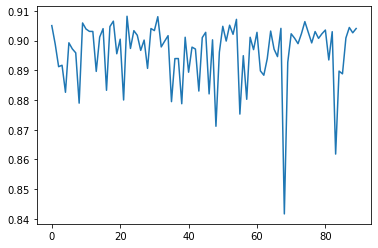

In [83]:
plt.plot(ms.df.index, ms.df['score']);

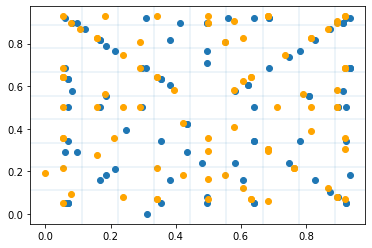

In [91]:
plt.scatter(ms.df.iloc[:,0],ms.df.iloc[:,1])
[(plt.axhline(b, alpha=.1), plt.axvline(b, alpha=.1)) for b in ms.bins[1:-1]];
plt.scatter(ms.df.iloc[:,1],ms.df.iloc[:,2], color='orange')

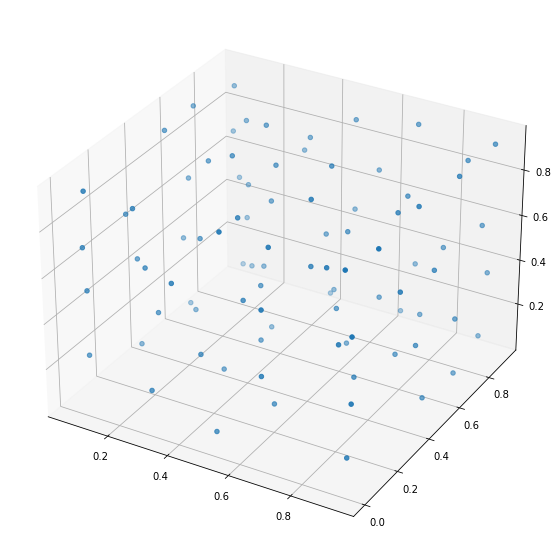

In [97]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(ms.df.iloc[:,0], ms.df.iloc[:,1], ms.df.iloc[:,2])

In [85]:
ms.best_parameters(full=True)

{'n_estimators': 8.901241001369609,
 'max_depth': 26.97844212472962,
 'min_samples_split': 99.16922402889035}

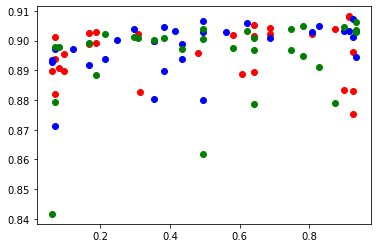

In [86]:
plt.scatter(ms.df.iloc[1::3,0], ms.df['score'][1::3], color = 'red')
plt.scatter(ms.df.iloc[0::3,0], ms.df['score'][0::3], color='blue')
plt.scatter(ms.df.iloc[2::3,0], ms.df['score'][2::3], color='green')

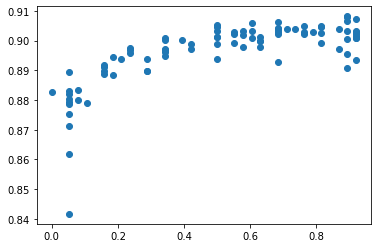

In [87]:
plt.scatter(ms.df.iloc[:,1], ms.df['score'])

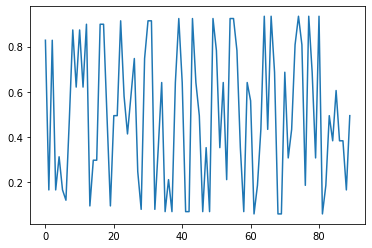

In [88]:
plt.plot(ms.df.iloc[:,0])

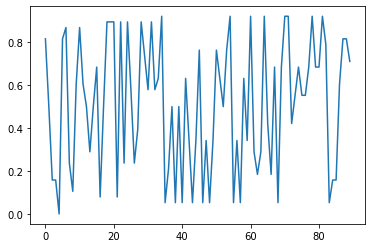

In [89]:
plt.plot(ms.df.iloc[:,1])